In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
df = pd.read_csv('combined.csv')
df.head()

,public_id,title,text,our rating
0,f2182a54,HUGE! Attorney Sidney Powell CONFIRMS Alleged ...,Last week Rep. Louie Gohmert told Chris Salced...,false
1,c5175d8d,Paul Ryan’s Worst Ally - The New York Times,WHATEVER drama plays out when Republicans meet...,true
2,213a870b,"You Can Get Jail Time Or $3,000 Fine For Not W...",Source page URL Title You Can Get Jail Time O...,false
3,392886ea,Antifa gearing up for false flag violence disg...,With merchants in Democrat-run cities boarding...,false
4,bc6d5d55,Remarks by President Biden on the Administrati...,State Dining Room 4:22 P.M. EST THE PRESIDEN...,partially false


In [5]:
X = df.drop('our rating', axis=1)
y = df['our rating']

X['total'] = X['title'] + ' ' + X['text']

encode = {"false": 0,
          "true": 1,
          "partially false": 2,
          "other": 3
          }
y = y.replace(encode)
print(y.value_counts())

0    335
2    100
1     31
3     21
Name: our rating, dtype: int64


In [6]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [7]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D

In [8]:
voc_size = 50000
words = X.copy()

In [9]:
import nltk
import re
from nltk.corpus import stopwords

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
corpus = []

for i in range(len(words)):
    review = re.sub('[^a-zA-Z]', ' ', words['total'][i])
    review = review.lower()
    review = review.split()
    review = [porter.stem(word) for word in review 
              if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)


In [12]:
onehot_repr = [one_hot(word, voc_size) for word in corpus]
onehot_repr

max_length = max([len(x) for x in onehot_repr])
max_length

3055

In [13]:
embedded_text = pad_sequences(onehot_repr, padding='pre', maxlen=max_length)
embedded_text

array([[    0,     0,     0, ..., 15337, 20543,  8814],
       [    0,     0,     0, ..., 11019, 43123,  3701],
       [    0,     0,     0, ..., 17610, 24000,  7652],
       ...,
       [    0,     0,     0, ..., 42678, 27650, 27443],
       [    0,     0,     0, ..., 29545,  1830,  3827],
       [    0,     0,     0, ...,  1660,  1087, 39270]], dtype=int32)

In [14]:
embedding_vector_features = 100
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, 
                    input_length=max_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3055, 100)         5000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 804       
Total params: 5,161,604
Trainable params: 5,161,604
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
X_processed = np.array(embedded_text)
y_processed = np.array(y)

X_processed.shape, y_processed.shape

((487, 3055), (487,))

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.20, random_state=69)

In [17]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=64)

Epoch 1/10
6/6 [==============================] - 51s 8s/step - loss: 1.3371 - accuracy: 0.6180 - val_loss: 1.1626 - val_accuracy: 0.6923
Epoch 2/10
6/6 [==============================] - 45s 7s/step - loss: 1.0754 - accuracy: 0.6718 - val_loss: 0.9688 - val_accuracy: 0.6923
Epoch 3/10
6/6 [==============================] - 46s 8s/step - loss: 0.8426 - accuracy: 0.7012 - val_loss: 0.9554 - val_accuracy: 0.6923
Epoch 4/10
6/6 [==============================] - 46s 8s/step - loss: 0.8793 - accuracy: 0.6682 - val_loss: 0.9254 - val_accuracy: 0.6923
Epoch 5/10
6/6 [==============================] - 45s 8s/step - loss: 0.7790 - accuracy: 0.6743 - val_loss: 0.8669 - val_accuracy: 0.6923
Epoch 6/10
6/6 [==============================] - 45s 8s/step - loss: 0.6295 - accuracy: 0.7075 - val_loss: 0.8510 - val_accuracy: 0.7949
Epoch 7/10
6/6 [==============================] - 46s 8s/step - loss: 0.5976 - accuracy: 0.8485 - val_loss: 0.8728 - val_accuracy: 0.7692
Epoch 8/10
6/6 [==================

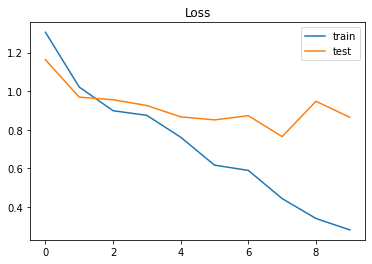

In [18]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

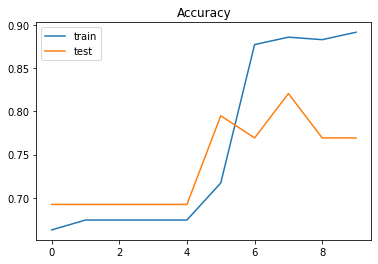

In [19]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [31]:
pred = model.predict_classes(X_test)
pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 2, 2, 0, 2])

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        69
           1       0.00      0.00      0.00         4
           2       0.83      1.00      0.91        24
           3       0.00      0.00      0.00         1

    accuracy                           0.94        98
   macro avg       0.45      0.50      0.47        98
weighted avg       0.90      0.94      0.92        98



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


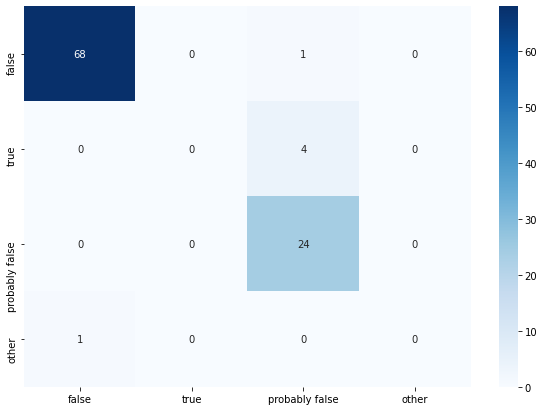

In [35]:
import seaborn as sn
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=['false', 'true', 'probably false', 'other'], 
                     columns=['false', 'true', 'probably false', 'other'])
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, cmap="Blues", annot=True)